In [121]:
import math 
import random 
import cv2
from PIL import Image
import pickle
import imageio
import cv2
import kornia as K
import kornia.geometry as KG
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [122]:
with open('10frame.pickle', 'rb') as f:
    rec = pickle.load(f)

In [125]:
# im1 = cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\002.png')
im1 = cv2.cvtColor(cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\001.png'), cv2.COLOR_BGR2RGB)
# im2 = cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\010.png')
im2 = cv2.cvtColor(cv2.imread(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\010.png'), cv2.COLOR_BGR2RGB)
intrinsic = rec['intrinsic']
extrinsic1 = rec['extrinsic'][0]
extrinsic2 = rec['extrinsic'][9]
position1 = rec['position'][0]
position2 = rec['position'][9]
depth1 = rec['depth'][0]
depth2 = rec['depth'][9]
transfrom1 = rec['get_transfrom'][0]
transfrom2 = rec['get_transfrom'][9]

In [131]:
t = np.eye(4)
for i in rec['get_transfrom'][1:]:
    t = i@t


In [133]:
#use kornia 2d no depth 
def load_timg(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                      
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)
    # load image with OpenCV                                                                         
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    # convert image to torch tensor                                                                  
    tensor = K.image_to_tensor(img, None).float() / 255.
    return K.color.bgr_to_rgb(tensor)

In [135]:
device = 'cuda'
Kimg1 = load_timg(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\001.png').to(device)
Kimg2 = load_timg(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\010.png').to(device)

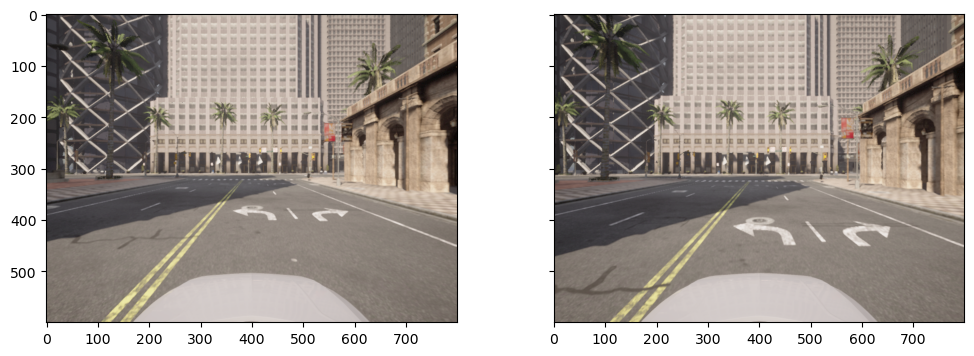

In [136]:
fig, axis = plt.subplots(1,2, figsize=(12,4), sharex='all', sharey='all', frameon=False)
axis[0].imshow(im1)
axis[1].imshow(im2)

In [137]:
device = 'cuda'
registrator = KG.ImageRegistrator('similarity', 
                                  loss_fn = F.mse_loss, 
                                  lr=8e-4, pyramid_levels=3, num_iterations=500).to(device)

In [138]:
m = registrator.register(Kimg2,Kimg1) 

In [151]:
m

tensor([[[ 1.0338e+00,  4.6067e-04, -2.4485e-03],
         [-4.6067e-04,  1.0338e+00,  3.3998e-03],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]], device='cuda:0',
       grad_fn=<CopySlices>)

In [139]:
timg_dst = KG.homography_warp(Kimg2, m, Kimg2.shape[-2:])

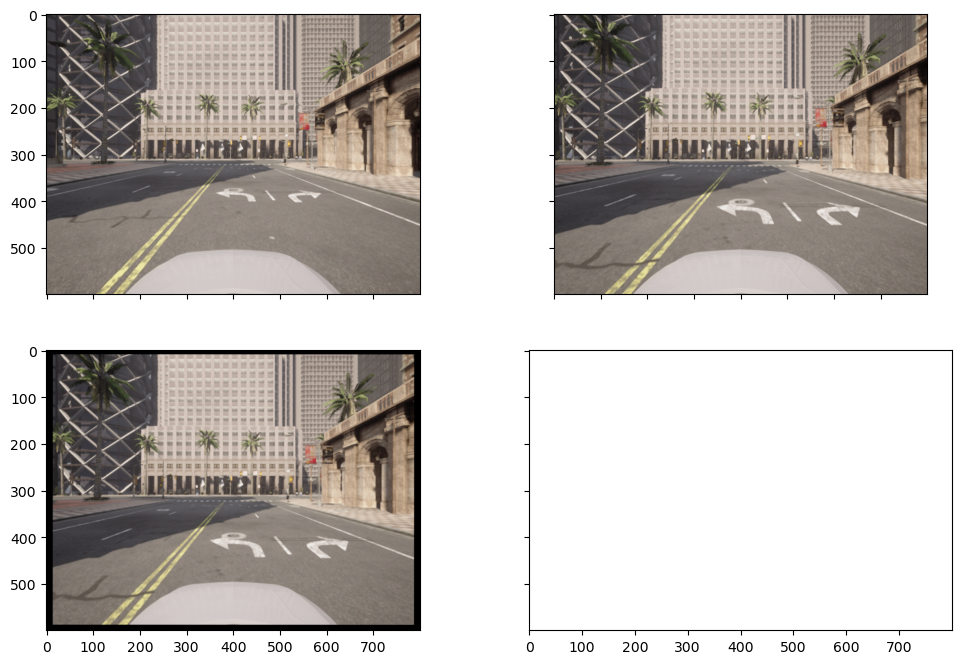

In [140]:
fig2, axis2 = plt.subplots(2,2, figsize=(12,8), sharex='all', sharey='all', frameon=False)
fig.suptitle('img1,img2')
axis2[0,0].imshow(K.tensor_to_image(Kimg1*255.).astype(np.uint8))
axis2[0,1].imshow(K.tensor_to_image(Kimg2*255.).astype(np.uint8))
axis2[1,0].imshow(K.tensor_to_image(timg_dst*255.).astype(np.uint8))#image2 rigistered to image1 


In [147]:
# R2 = T@R1
# T = R2@R1^-1

R1 = extrinsic1[:3,:3]
R2 = extrinsic2[:3,:3]
T = R2@np.linalg.inv(R1)


In [150]:
T

array([[ 9.99995495e-01, -3.34150552e-04, -2.98054215e-03],
       [ 3.39343403e-04,  9.99998433e-01,  1.74192153e-03],
       [ 2.97995514e-03, -1.74292518e-03,  9.99994013e-01]])

In [149]:
t

array([[ 1.05895640e-02,  9.99943559e-01,  7.70064442e-04,
        -4.62121463e+01],
       [-9.99943441e-01,  1.05889228e-02,  8.32732495e-04,
        -1.46417056e+01],
       [ 8.24530878e-04, -7.78839195e-04,  9.99999311e-01,
         1.76073796e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [107]:
torch.from_numpy(depth1[:,:,0]).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 600, 800])

In [113]:
#kornia 3d 

im1d = torch.cat([load_timg(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\002.png'),torch.from_numpy(depth1[:,:,0]).unsqueeze(0).unsqueeze(0)],axis=1).to(device)
im2d = torch.cat([load_timg(r'C:\Users\28340\Documents\UCL\finalYearProject\code\rgb_out\010.png'),torch.from_numpy(depth2[:,:,0]).unsqueeze(0).unsqueeze(0)],axis=1).to(device)


In [114]:
m_d = registrator.register(im2d,im1d)

RuntimeError: expected scalar type Double but found Float